In [1]:
import numpy as np
import sympy as sym
from scipy import linalg
import pandas as pd
import matplotlib.pyplot as plt

# Import for Simulation
import mujoco_py
import glfw
import time

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
class my_maths():
    
    def __init__(self) -> None:
        pass
    
    def SE3(self, SO3):
        temp = np.append(SO3, np.array([0,0,0]).reshape(1,-1), axis=0)
        temp = np.append(temp, np.array([0,0,0,1]).reshape(-1,1), axis=1)
        return temp

    def translate(self, X):
        """X should be [x,y,z]"""
        temp = np.identity(4)
        temp[0, 3] = X[0]
        temp[1, 3] = X[1]
        temp[2, 3] = X[2]
        return temp
    
    def Rx(self, theta):
        temp = np.array([
            [1, 0, 0],
            [0, sym.cos(theta), -sym.sin(theta)],
            [0, sym.sin(theta), sym.cos(theta)]
        ])
        return self.SE3(temp)

    def Ry(self, theta):
        temp = np.array([
            [sym.cos(theta), 0, sym.sin(theta)],
            [0, 1, 0],
            [-sym.sin(theta), 0, sym.cos(theta)]
        ])
        return self.SE3(temp)

    def Rz(self, theta):
        temp = np.array([
            [sym.cos(theta), -sym.sin(theta), 0],
            [sym.sin(theta), sym.cos(theta), 0],
            [0, 0, 1]
        ])
        return self.SE3(temp)

In [4]:
class DHRevolute(my_maths):
    def __init__(self, a=0, d=0, alpha=0):
        self.a = a
        self.d = d
        self.alpha = alpha

    def T(self, theta):
        return self.Rz(theta) @ self.translate([0,0,self.d]) @ self.translate([self.a,0,0]) @ self.Rx(self.alpha)

In [5]:
class robot(my_maths):

    def __init__(self, links, name, simulation=False, model_path=""):
        self.links = links
        self.name = name        
        self.simulation = simulation 
        
        if simulation:
            self.model_path = model_path
            self.setup_simulation()
            
    def setup_simulation(self):
        self.simulation = True
        model = mujoco_py.load_model_from_path(self.model_path)
        self.sim = mujoco_py.MjSim(model)
        self.current_angles = self.sim.data.ctrl[:]
        self.viewer = mujoco_py.MjViewer(self.sim)
        self.viewer.render()

    def reset_sim(self):
        glfw.destroy_window(self.viewer.window)
        self.setup_simulation()
    
    def close_sim(self):
        glfw.destroy_window(self.viewer.window)
        self.simulation = False
    
    def play(self, thetas, sim_horizon=1000, sleep_time=0.001):
        
        if len(thetas) == 7:
            thetas = np.append(thetas, np.array([0,0]))
            
        dt = (thetas - self.current_angles)/sim_horizon
        for i in range(sim_horizon):
            self.current_angles = self.current_angles + dt
            self.sim.data.ctrl[:] = self.current_angles
            self.sim.step()
            self.viewer.render()
            time.sleep(sleep_time)
        ## final steps
        for i in range(500):
            self.sim.step()
            self.viewer.render()
    
    def base_position(self):
        self.play(np.zeros(7))
        
    def fkine(self, thetas, sim=False):
        
        if len(thetas) < len(self.links):
            return f"Please give {len(self.links)} theta values"
        
        T = np.identity(4)
        for i, link in enumerate(self.links):
            T = T @ link.T(thetas[i])
        
        if self.simulation and sim:
            self.play(thetas)
            
        try:
            return T.astype(np.float16)
        except TypeError:
            return T

    def setup_inverse(self):
        theta_1 = sym.Symbol("theta_1")
        theta_2 = sym.Symbol("theta_2")
        theta_3 = sym.Symbol("theta_3")
        theta_4 = sym.Symbol("theta_4")
        theta_5 = sym.Symbol("theta_5")
        theta_6 = sym.Symbol("theta_6")
        theta_7 = sym.Symbol("theta_7")

        thetas = [theta_1, theta_2, theta_3, theta_4, theta_5, theta_6, theta_7]
        T_sym = self.fkine(thetas, False)


        F_sym = sym.Matrix([T_sym[0,0], T_sym[0,1], T_sym[0,2], T_sym[0,3], \
                        T_sym[1,0], T_sym[1,1], T_sym[1,2], T_sym[1,3], \
                        T_sym[2,0], T_sym[2,1], T_sym[2,2], T_sym[2,3],   ])

        J_sym = F_sym.jacobian(sym.Matrix([theta_1, theta_2, theta_3, theta_4, theta_5, theta_6, theta_7]))

        self.F_symnp = sym.lambdify([theta_1, theta_2, theta_3, theta_4, theta_5, theta_6, theta_7], F_sym, "numpy")
        self.J_symnp = sym.lambdify([theta_1, theta_2, theta_3, theta_4, theta_5, theta_6, theta_7], J_sym, "numpy")
                 
        
    def netwons_inverse(self, Tdest, verbose=False):             
        
        theta_init=2.0*np.random.rand(7, ).reshape(-1,1)*np.pi - np.pi
        
        df = pd.DataFrame(columns=['Theta1', 'Theta2', 'Theta3', 'Theta4', 'Theta5', 'Theta6', "Theta7"])
        df.loc[0] = [theta_init[0]] + [theta_init[1]] + [theta_init[2]] + [theta_init[3]] + [theta_init[4]] + [theta_init[5]] + [theta_init[6]]

        A = Tdest[:-1,:]
        A = A.reshape(-1,1)

        i = 0
        while i < 1000:
            
            temp1 = self.F_symnp(theta_init[0], theta_init[1],theta_init[2],theta_init[3],theta_init[4],theta_init[5],theta_init[6]).reshape(-1,1) - A
            temp1_5 = self.J_symnp(theta_init[0][0], theta_init[1][0],theta_init[2][0],theta_init[3][0],theta_init[4][0],theta_init[5][0], theta_init[6][0])
            temp2 = np.linalg.pinv(temp1_5)

            temp3 = np.matmul(temp2,temp1)  

            theta_init = theta_init - temp3
            for k in range(0,7):
                while abs(theta_init[k]) > np.pi:
                    theta_init[k] -= abs(theta_init[k])/theta_init[k]*np.pi

            df.loc[i+1] = [theta_init[0]] + [theta_init[1]] + [theta_init[2]] + [theta_init[3]] + [theta_init[4]] + [theta_init[5]] + [theta_init[6]]
            
            f = np.zeros(12)
            T = self.fkine(theta_init.ravel(), False)
            f[0] = (T[0][3]-Tdest[0][3])
            f[1] = (T[1][3]-Tdest[1][3])
            f[2] = (T[2][3]-Tdest[2][3])
            f[3] = (T[1][2]-Tdest[1][2])
            f[4] = (T[2][2]-Tdest[2][2])
            f[5] = (T[2][1]-Tdest[2][1])
            f[6] = (T[0][0]-Tdest[0][0])
            f[7] = (T[0][1]-Tdest[0][1])
            f[8] = (T[0][2]-Tdest[0][2])
            f[9] = (T[1][0]-Tdest[1][0])
            f[10] = (T[1][1]-Tdest[1][1])
            f[11] = (T[2][0]-Tdest[2][0])

            sum = 0.0
            for k in range(0,2*6):
                sum += pow(f[k],2.0)
            if sum < 0.0000000001:
                if verbose:
                    print(f"Converged")
                    print(f"Iteration ended in {i+1} iterations.") 
                    print(df)
                    print(f"Solution Theta Values = {theta_init.T*180/np.pi}")
                return theta_init.squeeze()
            i += 1

        if i >= 1000 and verbose:
            print("No solution found")
        elif i >= 1000:
            return 

    def jacob0(self, thetas):

        jacob_final = np.empty(shape= (6, 7))
        
        # T07 rotation matrix
        Rotation = self.fkine([thetas[0],thetas[1],thetas[2],thetas[3],thetas[4],thetas[5],thetas[6]])[:-1, :-1]

        # 12 rows, 7 columns jacobian
        jacobian_full = self.J_symnp(thetas[0],thetas[1],thetas[2],thetas[3],thetas[4],thetas[5],thetas[6])

        for i in range(7):
            jacob = jacobian_full[:,i].reshape(3,-1)
            skew_symmetric_matrix = jacob[:, :-1] @ Rotation.T

            jacob_final[0,i] = jacob[0, -1]
            jacob_final[1,i] = jacob[1, -1]
            jacob_final[2,i] = jacob[2, -1]

            jacob_final[3,i] = skew_symmetric_matrix[-1, 1]
            jacob_final[4,i] = skew_symmetric_matrix[0, -1]
            jacob_final[5,i] = skew_symmetric_matrix[1, 0]

        return jacob_final

    def joint_rates(self, thetas, end_effector_velocities):
        jacob0 = self.jacob0(thetas)
        xd = np.array(end_effector_velocities).reshape(-1,1)
        rates = np.linalg.pinv(jacob0) @ xd
        return rates.squeeze()

    def null_space_rates(self, thetas, joint_velocity):
        jacob0 = self.jacob0(thetas)
        joint_velocity = np.array(joint_velocity).reshape(-1,1)
        N = linalg.null_space(jacob0)
        return N @ np.linalg.pinv(N) @ joint_velocity 

    def manipulability(self, thetas):
        j0 = self.jacob0(thetas)
        return np.sqrt(np.linalg.det(j0 @ j0.T))

# Creating the robot

In [6]:
my_links = [
    DHRevolute(d=0.237,a=0.081,alpha=-np.pi/2),
    DHRevolute(d=0.1925,a=0,alpha=-np.pi/2),
    DHRevolute(d=0.4,a=0,alpha=-np.pi/2),
    DHRevolute(d=-0.1685,a=0,alpha=-np.pi/2),
    DHRevolute(d=0.4, a=0,alpha=-np.pi/2),
    DHRevolute(d=0.1363, a=0,alpha=-np.pi/2),
    DHRevolute(d=0.11, a=8.08e-7,alpha=0),
]

In [7]:
model = "sawyer_sim/sawyer.xml"

sawyer_robo = robot(my_links, "sawyer", True, model)

Creating window glfw


# Forward Kinematics

In [8]:
arr = sawyer_robo.fkine(np.array([-np.pi/4, -np.pi/2,np.pi/2, np.pi/2, np.pi/2, np.pi/2, np.pi/2]), True)
arr

array([[-0.707  ,  0.707  ,  0.     ,  0.8555 ],
       [ 0.707  ,  0.707  , -0.     , -0.01753],
       [-0.     , -0.     , -1.     ,  0.2954 ],
       [ 0.     ,  0.     ,  0.     ,  1.     ]], dtype=float16)

In [9]:
x = 1
y = 1
z = 1

vector_from_end_effector = np.array([x,y,z,1])

world = arr @ vector_from_end_effector
world

array([ 0.85546875,  1.39653015, -0.70458984,  1.        ])

In [10]:
sawyer_robo.base_position()

Change joint 0

In [38]:
# sawyer_robo.fkine([np.pi/2, 0, 0, 0, 0, 0, 0], True)
# sawyer_robo.fkine([0, 0, 0, 0, 0, 0, 0], True);

Change joint 1

In [12]:
# sawyer_robo.fkine([0, np.pi/2, 0, 0, 0, 0, 0], True)
# sawyer_robo.fkine([0, 0, 0, 0, 0, 0, 0], True);

Change joint 2

In [13]:
# sawyer_robo.fkine([0, 0, np.pi/2, 0, 0, 0, 0], True)
# sawyer_robo.fkine([0, 0, 0, 0, 0, 0, 0], True);

Change joint 3

In [14]:
# sawyer_robo.fkine([0, 0, 0, np.pi/2, 0, 0, 0], True)
# sawyer_robo.fkine([0, 0, 0, 0, 0, 0, 0], True);

Change joint 4

In [15]:
# sawyer_robo.fkine([0, 0, 0, 0, np.pi/2, 0, 0], True)
# sawyer_robo.fkine([0, 0, 0, 0, 0, 0, 0], True);

Change joint 5

In [16]:
# sawyer_robo.fkine([0, 0, 0, 0, 0, np.pi/2, 0], True)
# sawyer_robo.fkine([0, 0, 0, 0, 0, 0, 0], True);

Change joint 6

In [17]:
# sawyer_robo.fkine([0, 0, 0, 0, 0, 0, np.pi/2], True)
# sawyer_robo.fkine([0, 0, 0, 0, 0, 0, 0], True);

In [18]:
# sawyer_robo.close_sim()

In [19]:
# sawyer_robo.reset_sim()

In [20]:
sawyer_robo.current_angles

array([-6.57785458e-15, -1.31557092e-14,  1.31557092e-14,  1.31557092e-14,
        1.31557092e-14,  1.31557092e-14,  1.31557092e-14,  0.00000000e+00,
        0.00000000e+00])

# Inverse Kinematics

### Newtons Method

In [21]:
sawyer_robo.setup_inverse()

In [22]:
angles = np.array([np.pi/2, -np.pi/4, np.pi/4, -np.pi/8, -np.pi/8, np.pi/4, -np.pi/4])

In [23]:
Tdest = sawyer_robo.fkine(angles)
Tdest

array([[ 0.01662,  0.587  , -0.8096 , -0.3474 ],
       [ 0.9985 , -0.05118, -0.01662,  0.3625 ],
       [-0.05118, -0.808  , -0.587  ,  0.3845 ],
       [ 0.     ,  0.     ,  0.     ,  1.     ]], dtype=float16)

In [24]:
inverse_angles = sawyer_robo.netwons_inverse(Tdest)
inverse_angles

array([ 1.05964427, -1.14636082,  0.4976794 , -0.18045638, -0.2811583 ,
        1.53021589, -0.64297665])

In [25]:
sawyer_robo.fkine(inverse_angles)

array([[ 0.01662,  0.587  , -0.8096 , -0.3474 ],
       [ 0.9985 , -0.05118, -0.01662,  0.3625 ],
       [-0.05118, -0.808  , -0.587  ,  0.3845 ],
       [ 0.     ,  0.     ,  0.     ,  1.     ]], dtype=float16)

# Manipulator Jacobian

In [39]:
angles = np.array([np.pi/2, -np.pi/4, np.pi/4, -np.pi/8, -np.pi/8, np.pi/4, -np.pi/4])
jacob0 = sawyer_robo.jacob0(angles)
jacob0

array([[-3.62661495e-01, -8.20670215e-18,  3.03559084e-01,
        -2.15829904e-01, -8.77795659e-02, -4.69458990e-02,
         4.74247331e-07],
       [-3.47416139e-01,  1.47635878e-01,  1.09542253e-01,
        -2.26936261e-01, -1.23899810e-01, -7.36884712e-02,
        -4.13507520e-08],
       [ 0.00000000e+00, -2.81661495e-01,  1.09542253e-01,
        -7.82933165e-02, -3.96404811e-02,  6.68288245e-02,
        -6.52873329e-07],
       [ 0.00000000e+00, -9.99983881e-01, -1.09708213e-06,
         7.07096159e-01,  2.70594405e-01, -4.03276134e-01,
        -8.09447054e-01],
       [-3.07622034e-06,  6.12358788e-17,  7.07151998e-01,
        -5.00028897e-01, -4.61970483e-01,  7.42313388e-01,
        -1.66128301e-02],
       [ 1.00007416e+00,  8.52771852e-05, -7.07159218e-01,
        -5.00097378e-01,  8.44662757e-01,  5.35237148e-01,
        -5.86914263e-01]])

In [40]:
jacob0.shape

(6, 7)

Now consider that we want the end-effector to move at $0.2 \frac{m}{s}$ in the $x$, $y$ and $z$ directions.  

In [41]:
end_effector_velocities = [0.2,0.2,0.2,0,0,0]

sawyer_robo.joint_rates(angles, end_effector_velocities)

array([-0.3888681 , -0.68812759, -0.45417442, -0.81155528, -0.14131349,
       -0.19765005,  0.19240083])

# Manipulability

In [42]:
sawyer_robo.play(angles)

sawyer_robo.manipulability(angles)

0.027659711185380905

# Null space motion

In [30]:
angles = np.array([0, np.pi/3, 0, 0, 0, -np.pi/2, 0])

In [31]:
sawyer_robo.fkine(angles)

array([[ 0.866 , -0.    ,  0.5   ,  0.136 ],
       [-0.    , -1.    ,  0.    ,  0.4973],
       [ 0.5   , -0.    , -0.866 ,  0.1417],
       [ 0.    ,  0.    ,  0.    ,  1.    ]], dtype=float16)

Rotate joint 1 at -0.1 rad/s without changing end effector pose 

In [32]:
for i in range(15):
    joint_velocity = [0,-0.1,0,0,0,0,0]
    null_space_rates = sawyer_robo.null_space_rates(angles, joint_velocity)
    angles = angles + null_space_rates.squeeze()
    
angles

array([-2.28968257e-05,  2.94770347e-01, -1.04742118e-02, -4.39058411e-03,
       -1.04206602e-02, -8.22759638e-01,  1.25463277e-05])

In [33]:
sawyer_robo.fkine(angles)

array([[ 8.662e-01,  3.088e-05,  5.000e-01,  1.360e-01],
       [ 3.767e-05, -1.000e+00, -3.576e-06,  4.973e-01],
       [ 5.000e-01,  2.193e-05, -8.662e-01,  1.417e-01],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  1.000e+00]], dtype=float16)

# Trajectory

#  polynomial function of time.

quintic (fifth-order) polynomial

$s(t) = At^5 + Bt^4 + Ct^3 + Dt^2 + E^t + F$  
$v(t) = 5*At^4 + 4Bt^3 + 3ct^2 + 2D + E$  
$a(t) = 20At^3 + 12Bt^2 + 6Ct + 2D$  

$$
\left(\begin{matrix}
s_0\\
s_T\\
\dot{s_0}\\
\dot{s_T}\\
\ddot{s_0}\\
\ddot{s_T}\\
\end{matrix}\right)=
\left(\begin{matrix}
0 & 0 & 0 & 0 & 0 & 1\\
T^5 & T^4 & T^3 & T^2 & T & 1\\
0 & 0 & 0 & 0 & 1 & 0\\
5T^4 & 4T^3 & 3T^2 & 2T & 1 & 0\\
0 & 0 & 0 & 2 & 0 & 0\\
20T^3 & 12T^2 & 6T & 2 & 0 & 0\\
\end{matrix}\right)
\left(\begin{matrix}
A\\
B\\
C\\
D\\
E\\
F\\
\end{matrix}\right)
$$

In [34]:
def parabolic_trajectory(boundary, T, step=0.1, plot=False):
    """
    s,v,a [initial, final ...]
    T = time
    """
    b = np.array(boundary)
    A = np.array([
        [0,0,0,0,0,1],
        [T**5, T**4, T**3, T**2, T, 1],
        [0,0,0,0,1,0],
        [5*T**4, 4*T**3, 3*T**2, 2*T, 1, 0],
        [0,0,0,2,0,0],
        [20*T**3, 12*T**2, 6*T, 2, 0, 0] 
    ])

    A,B,C,D,E,F = np.linalg.solve(A,b)
    
    t = np.arange(0, T, step=step)
    t2 = np.power(t, 2)
    t3 = np.power(t, 3)
    t4 = np.power(t, 4)
    t5 = np.power(t, 5)

    s = A*t5 + B*t4 + C*t3 + D*t2 + E*t + F
    v = 5*A*t4 + 4*B*t3 + 3*C*t2 + 2*D*t + E
    a = 20*A*t3 + 12*B*t2 + 6*C*t + 2*D 

    if plot:
        fig,ax = plt.subplots(figsize=(15,10))
        ax.plot(t, s, label="position")
        ax.plot(t, v, label="velocity")
        ax.plot(t, a, label="acceleration")
        ax.set_title("Quintic poltnomial trajectory")
        ax.set_xlabel("time")
        ax.set_ylabel("s, s', s''")
        ax.legend()
        
    return s,v,a

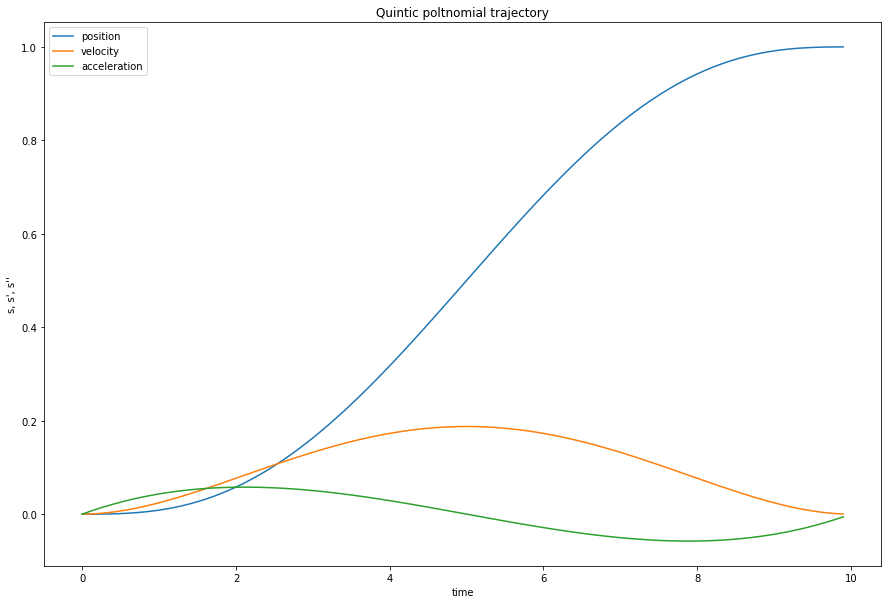

In [35]:
initial_pos = 0
final_pos = 1
initial_vel = 0
final_vel = 0
initial_acc = 0
final_acc = 0

s,v,a = parabolic_trajectory([initial_pos,final_pos,initial_vel,final_vel,initial_acc,final_acc], T = 10, plot=True)

### Linear segment with parabolic blend (LSPB) trajectory

In [36]:
def lspb(config, step=0.1, plot=False):
    """
    config = [t0, q0, tf, qf, V]
    """
    t0 = config[0]
    q0 = config[1]
    tf = config[2]
    qf = config[3]
    V = config[4]
    
    lower_boundary = (qf-q0)/tf
    upper_boundary = 2*lower_boundary
    if not lower_boundary < V and not V <= upper_boundary:
        print(f"V should be {lower_boundary} < V <= {upper_boundary}")
        return
    
    tb = (q0 - qf + V*tf)/V
    a0 = q0 
    a1 = 0
    a2 = V/(2*tb)

    b0 = qf - (V*tf**2)/(2*tb)
    b1 = V*tf/tb
    b2 = -V/(2*tb);

    t = np.arange(t0,tf,step=step)
    t2 = t**2
    
    first_ = t <= tb
    second_ = (t>tb) * (t < (tf-tb))
    third_ = t > (tf-tb)

    q1 = (a0 + a1*t + a2*t2) * first_ 
    q2 = ((qf + q0 - V*tf)/2 + V*t) * second_ 
    q3 = (b0 + b1*t + b2*t2) * third_;
    q = q1+q2+q3 

    qdot1 = (a1 + 2*a2*t) * first_ 
    qdot2 = V * second_
    qdot3 = (b1 + 2*b2*t) * third_
    qdot = qdot1 + qdot2 + qdot3

    qddot1 = 2*a2*first_
    qddot2 = 0 * second_
    qddot3 = 2*b2 * third_
    qddot = qddot1 + qddot2 + qddot3 

    if plot:
        fig, ax = plt.subplots(3,1, figsize=(15,10))
        fig.suptitle("LSPB", fontsize = 25)

        ax[0].plot(t, q, label="position")
        ax[0].grid(True)
        ax[0].set_xlabel("Time")
        ax[0].set_ylabel("s")
        ax[0].legend()

        ax[1].plot(t, qdot, color = "orange", label="velocity")
        ax[1].grid(True)
        ax[1].set_xlabel("Time")
        ax[1].set_ylabel("ds/dt")
        ax[1].legend()

        ax[2].plot(t, qddot, "g", label = "acceleration")
        ax[2].grid(True)
        ax[2].set_xlabel("Time")
        ax[2].set_ylabel("ds^2/dt^2")
        ax[2].legend()

    return q, qdot, qddot

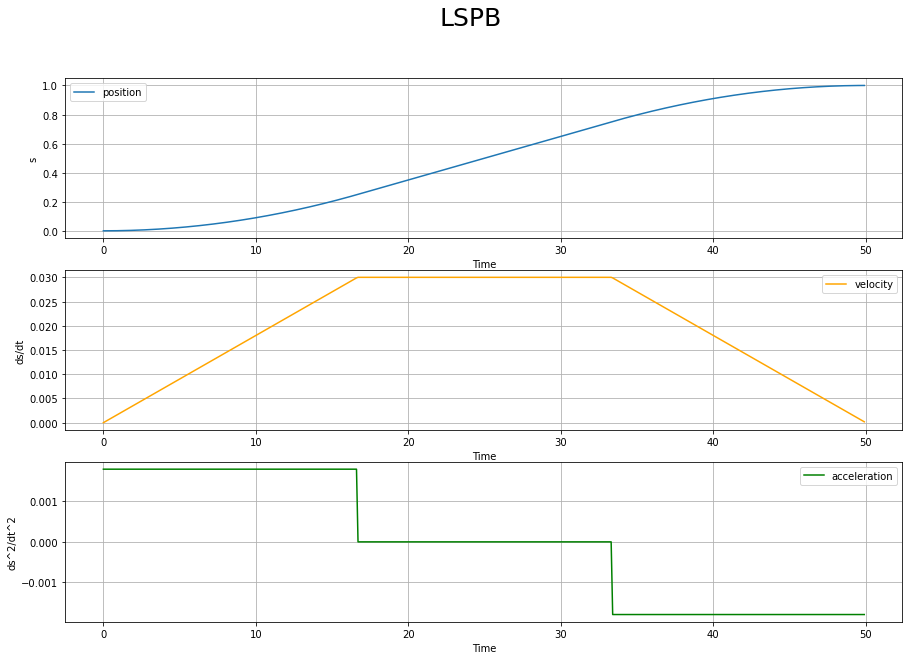

In [37]:
initial_time = 0
initial_position = 0
final_time = 50
final_position = 1
max_omega = 0.03

s, v, a = lspb([initial_time, initial_position, final_time, final_position, max_omega], plot = True)